## Modelos para la detección de Lesión Renal Aguda Postoperatoria

### Librerías

In [5]:
# importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [6]:
#Clonar repositorio
!git clone https://github.com/danielfce01/Monografia.git

Cloning into 'Monografia'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 96.29 KiB | 19.26 MiB/s, done.


### Conjuntos de datos

#### df_aki

Conjunto de datos del trabajo original :

Incidencia y factores de riesgo de Lesión Renal Aguda en cirugía no cardiovascular en un Hospital Universitario de Medellín, Colombia

Contiene 488 registros

Problema : marcado desbalance en la variable target lra (lesion renal aguda)

In [7]:
df_aki = pd.read_excel('/content/Monografia/data_final_balanceada.xlsx')
df_aki.head()

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,3,0,0.76,0,0,0,0,0
1,71,1,1,0,3,0,0.82,1,0,0,0,0
2,66,1,1,1,3,0,0.69,0,1,0,1,1
3,42,0,0,0,1,0,0.69,0,0,0,1,0
4,88,1,1,0,3,0,0.83,0,0,0,0,0


In [8]:
df_aki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      489 non-null    int64  
 1   dm                        489 non-null    int64  
 2   hta                       489 non-null    int64  
 3   ieca                      489 non-null    int64  
 4   asa                       489 non-null    int64  
 5   enfermedad_renal_cronica  489 non-null    int64  
 6   creatinina_basal          489 non-null    float64
 7   sepsis                    489 non-null    int64  
 8   choque_hipovolemico_      489 non-null    int64  
 9   cirugia_vascular          489 non-null    int64  
 10  prioridad_urgente         489 non-null    int64  
 11  lra                       489 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 46.0 KB


In [9]:
print(df_aki['lra'].value_counts())

lra
0    395
1     94
Name: count, dtype: int64


In [10]:
df_aki['asa'] = df_aki['asa'].replace({1: 0, 2: 0, 3: 1, 4: 1, 5: 1})
display(df_aki.head())

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,1,0,0.76,0,0,0,0,0
1,71,1,1,0,1,0,0.82,1,0,0,0,0
2,66,1,1,1,1,0,0.69,0,1,0,1,1
3,42,0,0,0,0,0,0.69,0,0,0,1,0
4,88,1,1,0,1,0,0.83,0,0,0,0,0


####df_mimic


In [11]:
df_mimic = pd.read_csv('/content/Monografia/1710 ap_aki_features.csv')
df_mimic.head()

,subject_id,hadm_id,stay_id,intime,outtime,edad,gender,race,admission_type,insurance,...,aki_scr_stage,aki_uo,aki_7d,glucose_mean_24h,urine_24h_ml,intake_24h_ml,output_24h_ml,balance_hidrico_24h_ml,peso_kg,balance_hidrico_24h_mlkg
0,10004606,29242151,30213599,2159-02-20 16:10:03,2159-02-25 20:09:14,64,F,WHITE,OBSERVATION ADMIT,Other,...,NaN,0,0,131.000000,NaN,5851.571321,2215.0,3636.571321,NaN,NaN
1,10007795,28477357,31921355,2136-04-22 18:01:13,2136-04-23 19:13:58,53,F,WHITE,URGENT,Medicare,...,3.0,0,1,133.000000,NaN,2492.500023,5900.0,-3407.499977,NaN,NaN
2,10012206,23961896,37675714,2127-07-04 02:08:00,2127-07-04 15:52:22,45,M,WHITE,OBSERVATION ADMIT,Other,...,NaN,0,0,108.000000,NaN,2417.583356,1525.0,892.583356,NaN,NaN
3,10017531,21095812,32136798,2159-12-26 20:14:53,2160-02-04 16:23:00,64,M,WHITE,URGENT,Other,...,3.0,0,1,207.666667,NaN,2948.151587,745.0,2203.151587,NaN,NaN
4,10017531,22580355,35526828,2159-09-22 19:30:55,2159-10-24 14:57:16,64,M,WHITE,URGENT,Other,...,1.0,0,1,202.333333,NaN,10595.584131,1295.0,9300.584131,NaN,NaN


In [12]:
df_mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_id                1069 non-null   int64  
 1   hadm_id                   1069 non-null   int64  
 2   stay_id                   1069 non-null   int64  
 3   intime                    1069 non-null   object 
 4   outtime                   1069 non-null   object 
 5   edad                      1069 non-null   int64  
 6   gender                    1069 non-null   object 
 7   race                      1069 non-null   object 
 8   admission_type            1069 non-null   object 
 9   insurance                 1069 non-null   object 
 10  first_careunit            1069 non-null   object 
 11  dm                        1069 non-null   int64  
 12  hta                       1069 non-null   int64  
 13  enfermedad_renal_cronica  1069 non-null   int64  
 14  sepsis  

In [13]:
df_mimic = df_mimic[['edad', 'dm', 'hta', 'enfermedad_renal_cronica', 'sepsis', 'choque_hipovolemico_', 'ieca', 'asa', 'creatinina_basal', 'aki_7d']]
df_mimic = df_mimic.rename(columns={'aki_7d': 'lra'})
display(df_mimic.head())

,edad,dm,hta,enfermedad_renal_cronica,sepsis,choque_hipovolemico_,ieca,asa,creatinina_basal,lra
0,64,0,1,0,0,0,1,0,1.3,0
1,53,0,1,0,0,0,0,0,0.6,1
2,45,1,1,0,0,0,0,0,1.7,0
3,64,1,1,0,0,0,0,1,1.2,1
4,64,1,1,0,0,0,0,0,1.7,1


In [14]:
# Imputar valores faltantes en creatinina_basal con la media
df_mimic["creatinina_basal"].fillna(df_mimic["creatinina_basal"].mean(), inplace=True)

/tmp/ipython-input-2185084524.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mimic["creatinina_basal"].fillna(df_mimic["creatinina_basal"].mean(), inplace=True)


In [15]:
df_mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1069 non-null   int64  
 1   dm                        1069 non-null   int64  
 2   hta                       1069 non-null   int64  
 3   enfermedad_renal_cronica  1069 non-null   int64  
 4   sepsis                    1069 non-null   int64  
 5   choque_hipovolemico_      1069 non-null   int64  
 6   ieca                      1069 non-null   int64  
 7   asa                       1069 non-null   int64  
 8   creatinina_basal          1069 non-null   float64
 9   lra                       1069 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 83.6 KB


In [16]:
print(df_mimic['lra'].value_counts())

lra
1    580
0    489
Name: count, dtype: int64


####df_udaki

In [17]:
df_mimic_2 = df_mimic.copy()

In [18]:
df_mimic_2['cirugia_vascular'] = 0
df_mimic_2['prioridad_urgente'] = 0

In [19]:
df_udaki = pd.concat([df_aki, df_mimic_2])
df_udaki.head()

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,1,0,0.76,0,0,0,0,0
1,71,1,1,0,1,0,0.82,1,0,0,0,0
2,66,1,1,1,1,0,0.69,0,1,0,1,1
3,42,0,0,0,0,0,0.69,0,0,0,1,0
4,88,1,1,0,1,0,0.83,0,0,0,0,0


In [20]:
df_udaki.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1558 entries, 0 to 1068
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1558 non-null   int64  
 1   dm                        1558 non-null   int64  
 2   hta                       1558 non-null   int64  
 3   ieca                      1558 non-null   int64  
 4   asa                       1558 non-null   int64  
 5   enfermedad_renal_cronica  1558 non-null   int64  
 6   creatinina_basal          1558 non-null   float64
 7   sepsis                    1558 non-null   int64  
 8   choque_hipovolemico_      1558 non-null   int64  
 9   cirugia_vascular          1558 non-null   int64  
 10  prioridad_urgente         1558 non-null   int64  
 11  lra                       1558 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 158.2 KB


In [44]:
print(df_udaki['lra'].value_counts())

lra
0    884
1    674
Name: count, dtype: int64


**Datos Sinteticos**

**CTGAN**


Es una variante de las GANs (Generative Adversarial Networks) adaptada a datos tabulares.

Las GAN clásicas funcionan bien con imágenes (datos continuos y distribuciones suaves), pero los datos tabulares tienen mixtura de variables continuas y categóricas, además de desbalances de clases (ej. sepsis casi siempre 0).

Puntos clave
1. 	Codificación de variables categóricas:
Usa one-hot encoding y un  mode-specific normalization para que las continuas se representen mejor según su distribución.

2. 	Entrenamiento condicional:
Durante el entrenamiento, el generador recibe como condición una categoría (ej. ) para forzar a la red a aprender a generar ejemplos de esa clase. Esto evita que ignore categorías raras.

3. 	GAN adversarial:
• 	El generador produce filas sintéticas.

• 	El discriminador intenta distinguir reales de sintéticas.

• 	Ambos se entrenan en oposición hasta que los sintéticos son indistinguibles.

• Captura bien dependencias no lineales y categorías poco frecuentes gracias al muestreo condicional.

**TVAE** :

Es una variante de los VAEs (Variational Autoencoders) diseñada para tablas.


•Puntyos clave

Los VAEs clásicos generan datos continuos, pero no categóricos. TVAE adapta la arquitectura para manejar ambos tipos.

1. 	Codificación probabilística:

• 	Las variables continuas se modelan como distribuciones gaussianas.

• 	Las categóricas se modelan como distribuciones categóricas (softmax).

2. 	Arquitectura encoder–decoder:

• 	El encoder toma una fila real y la mapea a un espacio latente probabilístico (media y varianza).

• 	El decoder toma un vector latente y reconstruye una fila (con continuas y categóricas).

3. 	Entrenamiento:
Se optimiza una función de pérdida que combina:

• 	Error de reconstrucción (qué tan bien reconstruye los datos).

• 	Divergencia KL (qué tan bien el espacio latente sigue una distribución normal estándar).

• Es más estable que una GAN, menos propenso a mode collapse, y funciona bien con datasets pequeños o medianos.

In [1]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.3/193.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.1 MB/s eta 0:00:00


In [2]:
!pip install --upgrade sdv

In [3]:
import sdv
print(sdv.__version__)

1.28.0


In [21]:
#conjunto de datos
df_udaki_sintetico=df_udaki.copy()

In [22]:
print("Cantidad de valores nulos y NaN en df_udaki_sintetico:")
print(df_udaki_sintetico.isnull().sum())

Cantidad de valores nulos y NaN en df_udaki_sintetico:
edad                        0
dm                          0
hta                         0
ieca                        0
asa                         0
enfermedad_renal_cronica    0
creatinina_basal            0
sepsis                      0
choque_hipovolemico_        0
cirugia_vascular            0
prioridad_urgente           0
lra                         0
dtype: int64


In [23]:
#Librerias
import pandas as pd
import numpy as np
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer
from sdv.evaluation.single_table import evaluate_quality
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import json
import os
import warnings
from sdv.metadata import SingleTableMetadata # Import SingleTableMetadata

In [24]:
# Define tus columnas continuas y categóricas aquí
CONT_COLS = ["edad", "creatinina_basal"]
CAT_COLS = [
    "dm", "hta", "enfermedad_renal_cronica",
    "ieca", "asa", "sepsis", "choque_hipovolemico_","cirugia_vascular", "prioridad_urgente",
]
TARGET = "lra"  # etiqueta AKI

OUTPUT_DIR = "synth_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def ensure_types(df, cont_cols, cat_cols):
    """Asegura los tipos de datos y maneja valores faltantes"""
    df = df.copy()
    # Continuas en float
    for c in cont_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype(float)
        # Manejar NaN en columnas continuas
        if df[c].isna().any():
            warnings.warn(f"Column {c} has NaN values. Filling with mean.")
            df[c] = df[c].fillna(df[c].mean())

    # Categóricas en object
    for c in cat_cols + [TARGET]:
        if c in df.columns:
            # Convertir a string y luego a object
            df[c] = df[c].astype(str).astype("object")
            # Manejar valores faltantes en categóricas
            if df[c].isna().any():
                df[c] = df[c].fillna("missing") # Fill with string 'missing' for object type
    return df

def encode_categoricals(df, cat_cols):
    """Codifica variables categóricas con LabelEncoder"""
    df = df.copy()
    encoders = {}
    for c in cat_cols + [TARGET]:
        if c in df.columns:
            le = LabelEncoder()
            # Manejar valores no vistos durante el entrenamiento
            unique_vals = df[c].unique()
            le.fit(unique_vals)
            df[c] = le.transform(df[c])
            encoders[c] = le
    return df, encoders

def decode_categoricals(df, encoders):
    """Decodifica variables categóricas"""
    df = df.copy()
    for c, le in encoders.items():
        if c in df.columns:
            # Manejar valores fuera del rango del encoder
            valid_indices = df[c].between(0, len(le.classes_) - 1)
            if not valid_indices.all():
                warnings.warn(f"Column {c} contains values outside encoder range. Clipping.")
                df[c] = df[c].clip(0, len(le.classes_) - 1)
            df[c] = le.inverse_transform(df[c].astype(int))
    return df

In [25]:
# 2) Preparación del dataset
# ============================================
def prepare_dataset(df_udaki):
    """Prepara el dataset para entrenamiento"""
    df = df_udaki_sintetico.copy()
    # Tipar columnas correctamente
    df = ensure_types(df, CONT_COLS, CAT_COLS)

    # Verificar que no hay valores NaN
    if df[CONT_COLS].isna().any().any() or df[CAT_COLS + [TARGET]].isna().any().any():
        warnings.warn("Dataset contains NaN values after preprocessing.")

    # SDV maneja categóricas automáticamente si son object/category,
    # pero para métricas externas usaremos una codificación auxiliar.
    df_enc, encoders = encode_categoricals(df, CAT_COLS + [TARGET])
    return df, df_enc, encoders


In [26]:
# 3) Entrenamiento paralelo CTGAN y TVAE
# ============================================
def train_models(df):
    """Entrena modelos CTGAN y TVAE con configuración robusta"""
    # Generate metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)

    # CTGAN con parámetros mejorados
    ctgan = CTGANSynthesizer(
        metadata=metadata, # Pass metadata
        epochs=300,
        verbose=True,
        cuda=True if os.getenv('CUDA_AVAILABLE') == 'true' else False,
        embedding_dim=128,
        generator_dim=(256, 256),
        discriminator_dim=(256, 256)
    )
    ctgan.fit(df)

    # TVAE con parámetros mejorados
    tvae = TVAESynthesizer(
        metadata=metadata, # Pass metadata
        epochs=300,
        verbose=True,
        cuda=True if os.getenv('CUDA_AVAILABLE') == 'true' else False,
        embedding_dim=128,
        compress_dims=(128, 128),
        decompress_dims=(128, 128)
    )
    tvae.fit(df)

    return ctgan, tvae

In [27]:
# ============================================
# 4) Muestreo sintético
# ============================================
def sample_models(ctgan, tvae, n_samples=1000):
    """Genera muestras sintéticas de los modelos"""
    try:
        synth_ctgan = ctgan.sample(n_samples)
        synth_tvae = tvae.sample(n_samples)
        return synth_ctgan, synth_tvae
    except Exception as e:
        warnings.warn(f"Error during sampling: {e}")
        # Fallback: muestreo por partes si falla el muestreo completo
        batch_size = min(500, n_samples)
        synth_ctgan_batches = []
        synth_tvae_batches = []

        for i in range(0, n_samples, batch_size):
            current_batch = min(batch_size, n_samples - i)
            synth_ctgan_batches.append(ctgan.sample(current_batch))
            synth_tvae_batches.append(tvae.sample(current_batch))

        synth_ctgan = pd.concat(synth_ctgan_batches, ignore_index=True)
        synth_tvae = pd.concat(synth_tvae_batches, ignore_index=True)

        return synth_ctgan, synth_tvae

In [28]:
# 5) Evaluación de calidad
# ============================================
def ks_eval(df_real, df_synth, cont_cols):
    """Evaluación KS para variables continuas"""
    results = []
    for c in cont_cols:
        if c not in df_real.columns or c not in df_synth.columns:
            warnings.warn(f"Column {c} not found in dataframes for KS test")
            continue

        r = df_real[c].dropna().astype(float)
        s = df_synth[c].dropna().astype(float)

        if len(r) == 0 or len(s) == 0:
            warnings.warn(f"Insufficient data for KS test on column {c}")
            continue

        stat, p = ks_2samp(r, s)
        results.append({
            "feature": c,
            "ks_stat": float(stat),
            "p_value": float(p),
            "significant_difference": str(p < 0.05) # Convert boolean to string
        })
    return results

def chi2_eval(df_real, df_synth, cat_cols):
    """Evaluación Chi-cuadrado para variables categóricas"""
    results = []
    for c in cat_cols:
        if c not in df_real.columns or c not in df_synth.columns:
            warnings.warn(f"Column {c} not found in dataframes for Chi2 test")
            continue

        # Tablas de frecuencia
        real_counts = df_real[c].value_counts().sort_index()
        synth_counts = df_synth[c].value_counts().sort_index()

        # Alinear índices y asegurar al menos 2 categorías
        idx = sorted(set(real_counts.index).union(set(synth_counts.index)))
        if len(idx) < 2:
            warnings.warn(f"Column {c} has insufficient categories for Chi2 test")
            continue

        real_vec = np.array([real_counts.get(i, 0) for i in idx])
        synth_vec = np.array([synth_counts.get(i, 0) for i in idx])

        # Verificar que hay suficientes observaciones
        if real_vec.sum() == 0 or synth_vec.sum() == 0:
            warnings.warn(f"Insufficient observations for Chi2 test on column {c}")
            continue

        table = np.vstack([real_vec, synth_vec])

        # Aplicar Chi2 solo si no hay celdas con frecuencia esperada < 5
        try:
            chi2, p, dof, expected = chi2_contingency(table)
            # Verificar supuesto de frecuencias esperadas
            if (expected < 5).any():
                warnings.warn(f"Chi2 test for {c} may be unreliable due to low expected frequencies")

            results.append({
                "feature": c,
                "chi2": float(chi2),
                "p_value": float(p),
                "degrees_of_freedom": int(dof),
                "significant_difference": str(p < 0.05) # Convert boolean to string
            })
        except Exception as e:
            warnings.warn(f"Chi2 test failed for {c}: {e}")
            continue

    return results

def correlation_preservation(df_real, df_synth, cols):
    """Evalúa preservación de correlaciones"""
    try:
        # Filtrar columnas existentes
        available_cols = [c for c in cols if c in df_real.columns and c in df_synth.columns]
        if len(available_cols) < 2:
            return {"error": "Insufficient columns for correlation analysis"}

        # Matrices de correlación
        real_corr = df_real[available_cols].corr(method="pearson")
        synth_corr = df_synth[available_cols].corr(method="pearson")

        # Diferencia promedio absoluta
        diff_matrix = np.abs(real_corr.values - synth_corr.values)
        np.fill_diagonal(diff_matrix, np.nan)  # Ignorar diagonal

        return {
            "real_corr": real_corr.to_dict(),
            "synth_corr": synth_corr.to_dict(),
            "mean_abs_diff": float(np.nanmean(diff_matrix)),
            "max_abs_diff": float(np.nanmax(diff_matrix))
        }
    except Exception as e:
        return {"error": str(e)}

def sdv_overall_score(df_real, df_synth):
    """Score integrado de SDV con manejo de errores"""
    try:
        # Generate metadata within the function
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data=df_real)
        score = evaluate_quality(df_synth, df_real, metadata=metadata)
        return float(score.get_score())
    except Exception as e:
        warnings.warn(f"SDV evaluation failed: {e}")
        return {"error": str(e)}

In [29]:
# 6) Chequeos de privacidad básicos
# ============================================
def nearest_neighbor_privacy(df_real_enc, df_synth_enc, cont_cols, cat_cols):
    """Evalúa privacidad mediante vecinos más cercanos"""
    try:
        # Filtrar columnas existentes
        available_cont = [c for c in cont_cols if c in df_real_enc.columns and c in df_synth_enc.columns]
        available_cat = [c for c in cat_cols if c in df_real_enc.columns and c in df_synth_enc.columns]

        if not available_cont and not available_cat:
            return {"error": "No available columns for privacy assessment"}

        # Normalizar variables continuas para métrica euclidiana
        scaler = StandardScaler()

        if available_cont:
            real_cont = scaler.fit_transform(df_real_enc[available_cont].values.astype(float))
            synth_cont = scaler.transform(df_synth_enc[available_cont].values.astype(float))
        else:
            real_cont = np.empty((len(df_real_enc), 0))
            synth_cont = np.empty((len(df_synth_enc), 0))

        # Combinar características
        if available_cat:
            real_cat = df_real_enc[available_cat].values.astype(float)
            synth_cat = df_synth_enc[available_cat].values.astype(float)

            real = np.hstack([real_cont, real_cat]) if available_cont else real_cat
            synth = np.hstack([synth_cont, synth_cat]) if available_cont else synth_cat
        else:
            real = real_cont
            synth = synth_cont

        if real.shape[1] == 0:
            return {"error": "No features available for distance calculation"}

        # NN en el espacio conjunto
        nn = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(real)
        dists, _ = nn.kneighbors(synth, n_neighbors=1)

        stats = {
            "mean_nn_distance": float(np.mean(dists)),
            "min_nn_distance": float(np.min(dists)),
            "max_nn_distance": float(np.max(dists)),
            "p05_nn_distance": float(np.percentile(dists, 5)),
            "p95_nn_distance": float(np.percentile(dists, 95)),
        }
        return stats
    except Exception as e:
        return {"error": f"Privacy assessment failed: {str(e)}"}

def duplication_check(df_real, df_synth):
    """Chequeo de duplicados exactos"""
    try:
        # Usar todas las columnas comunes
        common_cols = list(set(df_real.columns) & set(df_synth.columns))
        if not common_cols:
            return {"exact_duplicates": 0, "error": "No common columns"}

        # Convertir a string para comparación robusta
        real_str = df_real[common_cols].astype(str)
        synth_str = df_synth[common_cols].astype(str)

        # Encontrar duplicados
        inter = pd.merge(synth_str, real_str.drop_duplicates(), how="inner")
        duplicate_ratio = len(inter) / len(df_synth)

        return {
            "exact_duplicates": int(len(inter)),
            "duplicate_ratio": float(duplicate_ratio),
            "risk_level": "high" if duplicate_ratio > 0.01 else "low"
        }
    except Exception as e:
        return {"error": f"Duplication check failed: {str(e)}"}

In [32]:
# 7) Orquestación y reporte
# ============================================
def run_pipeline(df_udaki, n_samples=1000, save=True):
    """Ejecuta el pipeline completo de generación y evaluación"""
    # Preparación
    df_real, df_real_enc, encoders = prepare_dataset(df_udaki_sintetico)

    # Verificar tamaño del dataset
    if len(df_real) < 100:
        warnings.warn("Small dataset may affect model performance")

    # Entrenamiento
    print("Training CTGAN...")
    ctgan, tvae = train_models(df_real)

    # Muestreo
    print("Sampling synthetic data...")
    synth_ctgan, synth_tvae = sample_models(ctgan, tvae, n_samples=n_samples)

    # Asegurar tipos en datos sintéticos
    synth_ctgan = ensure_types(synth_ctgan, CONT_COLS, CAT_COLS)
    synth_tvae = ensure_types(synth_tvae, CONT_COLS, CAT_COLS)

    # Guardado crudo
    if save:
        try:
            synth_ctgan.to_json(f"{OUTPUT_DIR}/synthetic_ctgan.json", orient="records", force_ascii=False, indent=2)
            synth_tvae.to_json(f"{OUTPUT_DIR}/synthetic_tvae.json", orient="records", force_ascii=False, indent=2)
            ctgan.save(f"{OUTPUT_DIR}/ctgan.pkl")
            tvae.save(f"{OUTPUT_DIR}/tvae.pkl")
            print("Models and synthetic data saved successfully")
        except Exception as e:
            warnings.warn(f"Error saving files: {e}")

    # Evaluación SDV global
    print("Evaluating synthetic data quality...")
    sdv_score_ctgan = sdv_overall_score(df_real, synth_ctgan)
    sdv_score_tvae = sdv_overall_score(df_real, synth_tvae)

    # Preparar datos codificados para evaluación
    synth_ctgan_enc, _ = encode_categoricals(synth_ctgan, CAT_COLS + [TARGET])
    synth_tvae_enc, _ = encode_categoricals(synth_tvae, CAT_COLS + [TARGET])

    # Métricas KS y chi²
    ks_ctgan = ks_eval(df_real, synth_ctgan, CONT_COLS)
    ks_tvae = ks_eval(df_real, synth_tvae, CONT_COLS)

    chi_ctgan = chi2_eval(df_real_enc, synth_ctgan_enc, CAT_COLS + [TARGET])
    chi_tvae = chi2_eval(df_real_enc, synth_tvae_enc, CAT_COLS + [TARGET])

    # Preservación de correlaciones
    corr_ctgan = correlation_preservation(df_real, synth_ctgan, CONT_COLS)
    corr_tvae = correlation_preservation(df_real, synth_tvae, CONT_COLS)

    # Privacidad
    nn_priv_ctgan = nearest_neighbor_privacy(df_real_enc, synth_ctgan_enc, CONT_COLS, CAT_COLS)
    nn_priv_tvae = nearest_neighbor_privacy(df_real_enc, synth_tvae_enc, CONT_COLS, CAT_COLS)

    dup_ctgan = duplication_check(df_real, synth_ctgan)
    dup_tvae = duplication_check(df_real, synth_tvae)

    report = {
        "dataset_info": {
            "original_size": len(df_real),
            "synthetic_size": n_samples,
            "continuous_columns": CONT_COLS,
            "categorical_columns": CAT_COLS,
            "target_column": TARGET
        },
        "sdv_scores": {"ctgan": sdv_score_ctgan, "tvae": sdv_score_tvae},
        "ks_continuous": {"ctgan": ks_ctgan, "tvae": ks_tvae},
        "chi2_categorical": {"ctgan": chi_ctgan, "tvae": chi_tvae},
        "correlation_preservation": {"ctgan": corr_ctgan, "tvae": corr_tvae},
        "privacy": {
            "nearest_neighbor": {"ctgan": nn_priv_ctgan, "tvae": nn_priv_tvae},
            "exact_duplications": {"ctgan": dup_ctgan, "tvae": dup_tvae}
        },
        "warnings": []
    }

    if save:
        try:
            with open(f"{OUTPUT_DIR}/evaluation_report.json", "w", encoding="utf-8") as f:
                json.dump(report, f, ensure_ascii=False, indent=2)
            print("Evaluation report saved successfully")
        except Exception as e:
            warnings.warn(f"Error saving report: {e}")

    return report, synth_ctgan, synth_tvae

In [33]:
# 8) Ejecución
# ============================================
if __name__ == "__main__":
    # Ejemplo de uso:
    # from your_data_module import df_udaki  # importa tus datos aquí
    report, synth_ctgan, synth_tvae = run_pipeline(df_udaki_sintetico, n_samples=1000, save=True)
    print(json.dumps(report, indent=2, ensure_ascii=False))
    print("Synthetic data generation pipeline ready. Import this module and call run_pipeline() with your data.")

Training CTGAN...


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Gen. (-2.10) | Discrim. (0.10): 100%|██████████| 300/300 [01:08<00:00,  4.41it/s]
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/ctgan/s

Sampling synthetic data...
Models and synthetic data saved successfully
Evaluating synthetic data quality...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 487.61it/s]|
Column Shapes Score: 90.76%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 190.22it/s]|
Column Pair Trends Score: 84.22%

Overall Score (Average): 87.49%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 499.28it/s]|
Column Shapes Score: 90.82%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 177.17it/s]|
Column Pair Trends Score: 84.67%

Overall Score (Average): 87.74%

Evaluation report saved successfully
{
  "dataset_info": {
    "original_size": 1558,
    "synthetic_size": 1000,
    "continuous_columns": [
      "edad",
      "creatinina_basal"
    ],
    "categorical_columns": [
      "dm",
      "hta",
      "enfermedad_renal_cronica",
      "ieca",
      "asa",
      "sepsis",
      "choqu

**Analisis**

Calidad global

• 	Overall Score ≈ 87.9%

• 	CTGAN ≈ 0.90, TVAE ≈ 0.88

Edad y crearinina basasl

tanto CTGAN como TVAE muestran ks_stat > 0.12 y p-values muy bajos → hay diferencias significativas.

Esto es esperado y positivo: significa que los datos sintéticos no son idénticos, sino que introducen variación.

Variables categoricas

CTGAN : diferencias significativas en HTA,ieca ,asa ,sepsis ,cirugia vascular ,prioridad urgente , y en el target lra

TVAE: diferencias significativas en dm, enfermedad reanl cronica ,ieca ,asa ,sepsis ,choque hipovoelmica ,cirugia vascular  y prioridad urgente .

cada modelo “aprendió” de forma distinta las proporciones de categorías.

CTGAN performa mejor en categóricas:

Correlaciones

CTGAN: pasó de correlación real edad-creatinina 0.04  a -0.018  → perdió la dirección de la relación.

TVAE: la infló a 0.26 → exageró la asociación.

Privacidad

CTGAN: solo 1 duplicado exacto (0.1%).

TVAE: 0 duplicados.

Distancias de nearest neighbor:

• CTGAN: media ≈ 0.52 (más lejos de los originales).

• TVAE: media ≈ 0.08 (más cerca de los originales, pero sin duplicar).


In [34]:
# combinar df_udaki con CTGAN syntheti y tvae synth
df_udaki_ctgan = pd.concat([df_udaki_sintetico, synth_ctgan], ignore_index=True)
df_udaki_tvae = pd.concat([df_udaki_sintetico, synth_tvae], ignore_index=True)

Visualizacion

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance, ks_2samp

def evaluar_calidad_datos(df_real_features, df_sintetico_features):
    """
    Evalúa la calidad de los datos sintéticos comparándolos con los reales.

    Parámetros:
    df_real_features: DataFrame con las características de los datos reales (sin variable objetivo)
    df_sintetico_features: DataFrame con las características de los datos sintéticos (sin variable objetivo)
    """

    # Asegurarnos de que las columnas booleanas se conviertan a enteros (por si acaso)
    for col in df_real_features.select_dtypes(include='bool').columns:
        df_real_features[col] = df_real_features[col].astype(int)
    for col in df_sintetico_features.select_dtypes(include='bool').columns:
        df_sintetico_features[col] = df_sintetico_features[col].astype(int)

    # Combinar características reales y sintéticas para normalizar
    X_combinado = pd.concat([df_real_features, df_sintetico_features], ignore_index=True)

    # Normalizar los datos combinados
    scaler = StandardScaler()
    X_combinado_normalizado = scaler.fit_transform(X_combinado)

    # Separar nuevamente en real y sintético
    X_real_normalizado = X_combinado_normalizado[:len(df_real_features)]
    X_sint_normalizado = X_combinado_normalizado[len(df_real_features):]

    # Aplicar PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_combinado_normalizado)
    pca_real = pca_result[:len(df_real_features)]
    pca_sint = pca_result[len(df_real_features):]

    # Aplicar t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_combinado_normalizado)-1))
    tsne_result = tsne.fit_transform(X_combinado_normalizado)
    tsne_real = tsne_result[:len(df_real_features)]
    tsne_sint = tsne_result[len(df_real_features):]

    # Crear figura
    plt.figure(figsize=(18, 6))

    # Visualización PCA
    plt.subplot(1, 3, 1)
    plt.scatter(pca_real[:, 0], pca_real[:, 1], alpha=0.5, label='Real', color='blue')
    plt.scatter(pca_sint[:, 0], pca_sint[:, 1], alpha=0.5, label='Sintético', color='red')
    plt.title('PCA: Datos Reales vs Sintéticos')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()

    # Visualización t-SNE
    plt.subplot(1, 3, 2)
    plt.scatter(tsne_real[:, 0], tsne_real[:, 1], alpha=0.5, label='Real', color='blue')
    plt.scatter(tsne_sint[:, 0], tsne_sint[:, 1], alpha=0.5, label='Sintético', color='red')
    plt.title('t-SNE: Datos Reales vs Sintéticos')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()

    # Histograms for all features
    num_features = X_real_normalizado.shape[1]
    if num_features > 0:
        plt.subplot(1, 3, 3)
        plt.hist(X_real_normalizado[:, 0], alpha=0.7, label='Real', bins=20, density=True, color='blue')
        plt.hist(X_sint_normalizado[:, 0], alpha=0.7, label='Sintético', bins=20, density=True, color='red')
        plt.title('Distribución de la Característica 1 (Normalizada)')
        plt.legend()


    plt.tight_layout()
    plt.show()

    # Estadísticas comparativas
    print("=== ESTADÍSTICAS COMPARATIVAS (Normalizadas) ===")
    print(f"Datos reales - Media: {np.mean(X_real_normalizado, axis=0)}")
    print(f"Datos sintéticos - Media: {np.mean(X_sint_normalizado, axis=0)}")
    print(f"Datos reales - Std: {np.std(X_real_normalizado, axis=0)}")
    print(f"Datos sintéticos - Std: {np.std(X_sint_normalizado, axis=0)}")


    # Comparación de distribuciones por característica usando KS test
    print("\n=== COMPARACIÓN DE DISTRIBUCIONES POR CARACTERÍSTICA (Test KS) ===")
    for i, col in enumerate(df_real_features.columns):
        ks_stat, ks_p_value = ks_2samp(X_real_normalizado[:, i], X_sint_normalizado[:, i])
        print(f"Característica '{col}': KS Statistic={ks_stat:.4f}, P-Value={ks_p_value:.4f}")

In [36]:
# Separar las clases
clase_mayoritaria = df_udaki_sintetico[df_udaki_sintetico['lra'] == 0]
clase_minoritaria = df_udaki_sintetico[df_udaki_sintetico['lra'] == 1]

print(f"Clase mayoritaria (lra=0): {len(clase_mayoritaria)} muestras")
print(f"Clase minoritaria (lra=1): {len(clase_minoritaria)} muestras")

Clase mayoritaria (lra=0): 884 muestras
Clase minoritaria (lra=1): 674 muestras


**df_udaki_tavae**

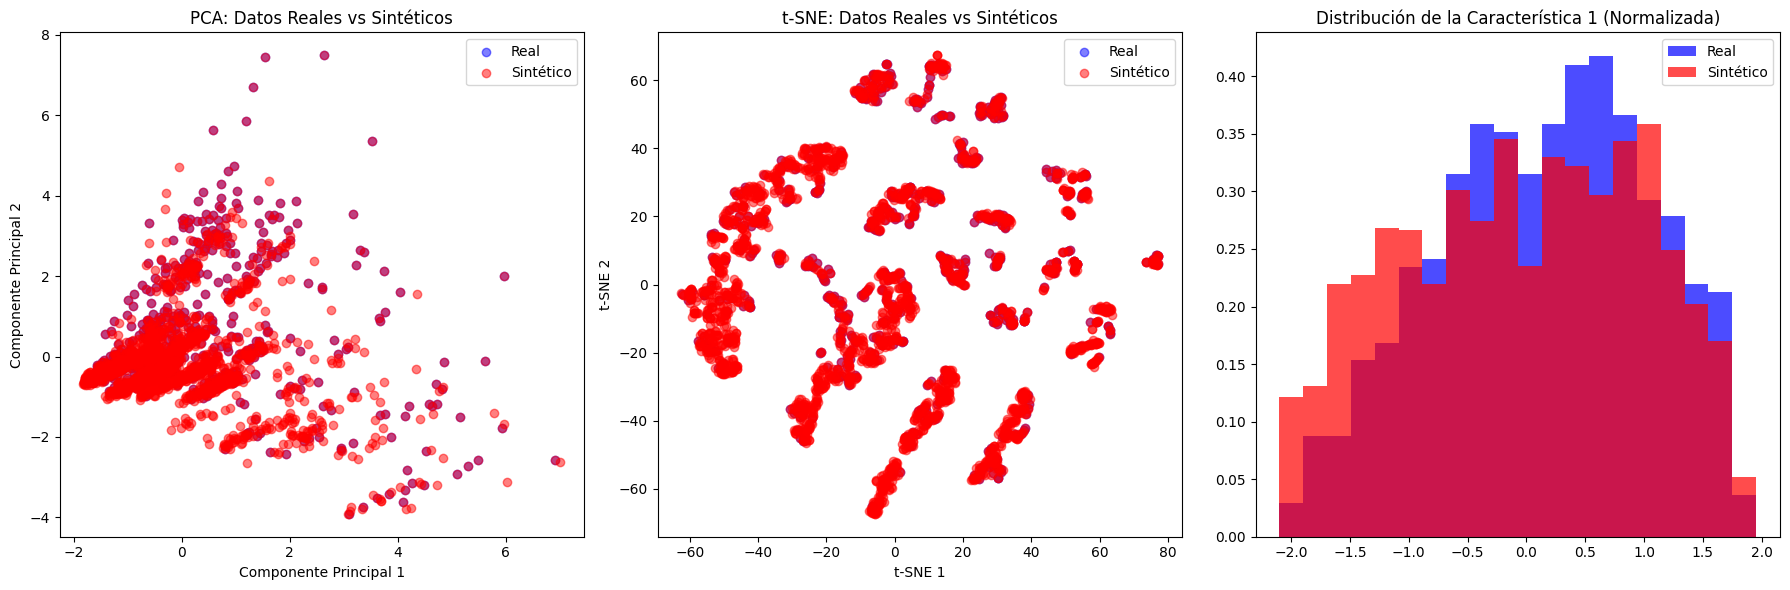

=== ESTADÍSTICAS COMPARATIVAS (Normalizadas) ===
Datos reales - Media: [ 0.13688192  0.29191304  0.02646173  0.1024814  -0.03448143  0.3175922
  0.33555218  0.07435655  0.14810839  0.03523749 -0.04978381]
Datos sintéticos - Media: [-0.03606662 -0.07691532 -0.00697232 -0.02700253  0.00908541 -0.08368145
 -0.08841367 -0.01959199 -0.03902465 -0.00928462  0.01311739]
Datos reales - Std: [0.90668786 1.15308778 1.0039218  1.20465587 0.98778772 1.26521241
 1.35152527 1.19662218 1.35991673 1.15196918 0.91005635]
Datos sintéticos - Std: [1.02011823 0.94062909 0.99884741 0.9368134  1.00299573 0.89895922
 0.86296684 0.94040314 0.87686843 0.95572886 1.02197911]

=== COMPARACIÓN DE DISTRIBUCIONES POR CARACTERÍSTICA (Test KS) ===
Característica 'edad': KS Statistic=0.0960, P-Value=0.0001
Característica 'dm': KS Statistic=0.1503, P-Value=0.0000
Característica 'hta': KS Statistic=0.0165, P-Value=0.9981
Característica 'ieca': KS Statistic=0.0263, P-Value=0.8437
Característica 'asa': KS Statistic=0.0207

In [37]:
evaluar_calidad_datos(clase_minoritaria.drop('lra', axis=1), df_udaki_tvae.drop('lra', axis=1))

Los puntos azules (reales) y rojos (sintéticos) ocupan regiones similares, pero los sintéticos aparecen más densamente agrupados.

la TVAE capturó la estructura global, pero suavizó la variabilidad: menos dispersión que los datos reales.

En tSNE Los datos sintéticos (rojo) forman clusters más definidos que los reales

sugiere que la TVAE tiende a exagerar patrones latentes y a separar grupos que en la realidad son más difusos.

La curva de distribucion de las variables la forma general de la curva se conserva, pero hay diferencias en la densidad en ciertos rangos. La TVAE respeta la tendencia general de las variables

La TVAE genera datos sintéticos realistas, pero más “limpios” y agrupados que los reales

**df_udaki_ctgan**

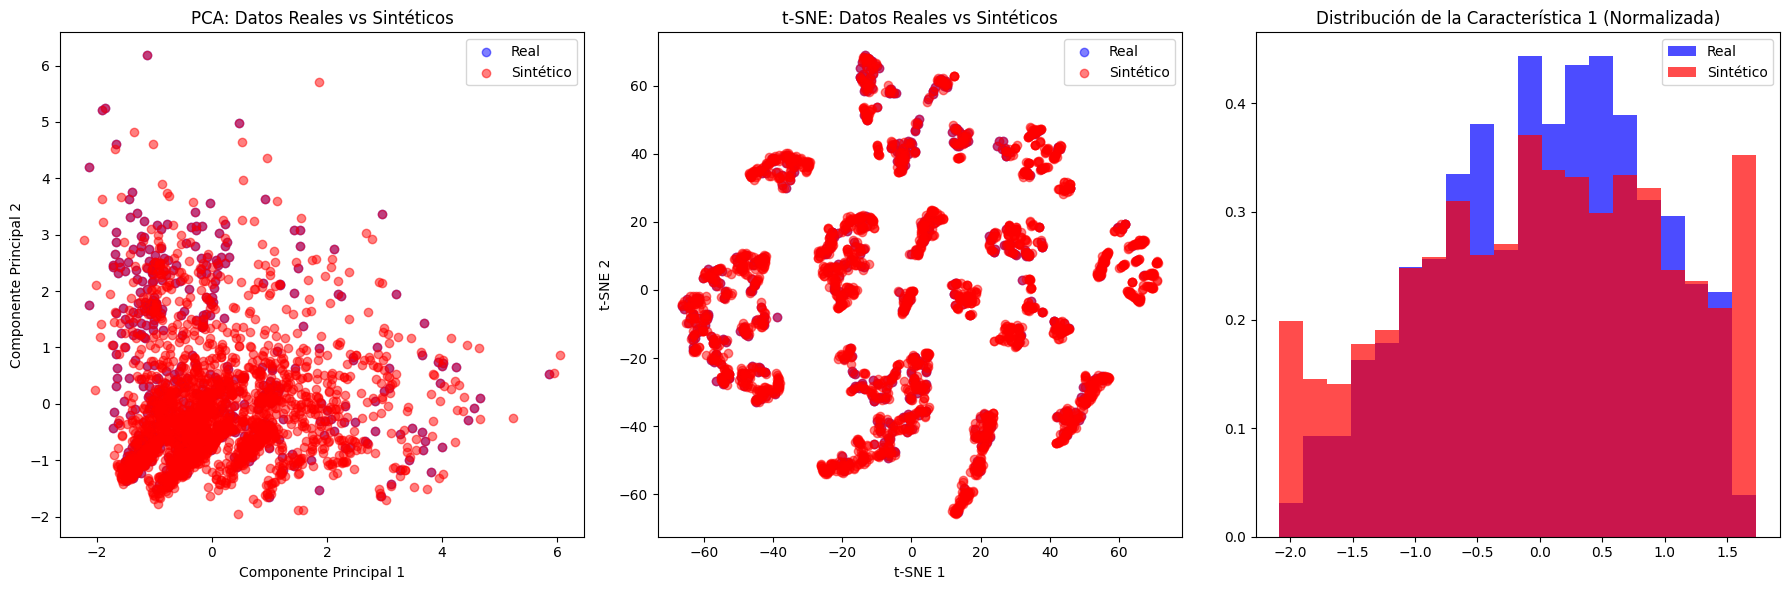

=== ESTADÍSTICAS COMPARATIVAS (Normalizadas) ===
Datos reales - Media: [ 0.02116577 -0.04566764 -0.09955418 -0.04859529 -0.02347661  0.24358918
  0.10585312 -0.06998142 -0.00691524 -0.07464884 -0.15264655]
Datos sintéticos - Media: [-0.00557691  0.01203283  0.02623124  0.01280423  0.00618578 -0.06418261
 -0.02789093  0.0184392   0.00182208  0.01966901  0.0402204 ]
Datos reales - Std: [0.85381204 0.98460041 0.99161911 0.9181954  0.99153818 1.19185594
 1.05263665 0.84869692 0.98592046 0.7470085  0.75973786]
Datos sintéticos - Std: [1.03501555 1.00367246 1.0005491  1.02007818 1.00212615 0.93244016
 0.98376907 1.03540838 1.00366897 1.05574639 1.05054497]

=== COMPARACIÓN DE DISTRIBUCIONES POR CARACTERÍSTICA (Test KS) ===
Característica 'edad': KS Statistic=0.0632, P-Value=0.0268
Característica 'dm': KS Statistic=0.0275, P-Value=0.8005
Característica 'hta': KS Statistic=0.0629, P-Value=0.0281
Característica 'ieca': KS Statistic=0.0163, P-Value=0.9984
Característica 'asa': KS Statistic=0.014

In [38]:
evaluar_calidad_datos(clase_minoritaria.drop('lra', axis=1), df_udaki_ctgan.drop('lra', axis=1))

aparecen los sintéticos (rojo), y se forman clusters definidos

CTGAN tiende a crear grupos artificialmente más claros que los reales.

CTGAN: más diverso y con mejor privacidad, pero tiende a “compactar” los datos y a distorsionar correlaciones.

**Gradient Boosting con TVAE**

In [39]:
df_udaki_tvae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      2558 non-null   float64
 1   dm                        2558 non-null   object 
 2   hta                       2558 non-null   object 
 3   ieca                      2558 non-null   object 
 4   asa                       2558 non-null   object 
 5   enfermedad_renal_cronica  2558 non-null   object 
 6   creatinina_basal          2558 non-null   float64
 7   sepsis                    2558 non-null   object 
 8   choque_hipovolemico_      2558 non-null   object 
 9   cirugia_vascular          2558 non-null   object 
 10  prioridad_urgente         2558 non-null   object 
 11  lra                       2558 non-null   object 
dtypes: float64(2), object(10)
memory usage: 239.9+ KB


In [40]:
columns_to_convert = ['dm', 'hta', 'ieca', 'asa', 'enfermedad_renal_cronica', 'sepsis', 'choque_hipovolemico_', 'cirugia_vascular', 'prioridad_urgente', 'lra']
for col in columns_to_convert:
    # Convert to numeric, coercing errors to NaN, then fill NaN with a placeholder if needed
    # and finally convert to integer. Using errors='coerce' handles non-numeric values.
    df_udaki_tvae[col] = pd.to_numeric(df_udaki_tvae[col], errors='coerce').fillna(-1).astype(int) # Fill NaN with -1 or another appropriate value before converting to int

print("Data types after conversion:")
print(df_udaki_tvae.info())

Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      2558 non-null   float64
 1   dm                        2558 non-null   int64  
 2   hta                       2558 non-null   int64  
 3   ieca                      2558 non-null   int64  
 4   asa                       2558 non-null   int64  
 5   enfermedad_renal_cronica  2558 non-null   int64  
 6   creatinina_basal          2558 non-null   float64
 7   sepsis                    2558 non-null   int64  
 8   choque_hipovolemico_      2558 non-null   int64  
 9   cirugia_vascular          2558 non-null   int64  
 10  prioridad_urgente         2558 non-null   int64  
 11  lra                       2558 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 239.9 KB
None


In [41]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, recall_score, precision_score, accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Configuración reproducible
np.random.seed(42)

# Cargar datos
X = df_udaki_tvae.drop('lra', axis=1)
y = df_udaki_tvae['lra']

# Ensure the target variable 'lra' is of a consistent type (integer)
y = pd.to_numeric(y, errors='coerce').astype(int)


# 1. Dividir datos manteniendo proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en test: {np.bincount(y_test)}")

# 2. Crear pipeline mejorado con manejo de desbalanceo
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Manejar valores missing
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),  # Balancear clases
    ('gb', GradientBoostingClassifier(random_state=42))
])

# 3. Espacio de hiperparámetros más inteligente y amplio
param_dist = {
    'gb__n_estimators': [100, 200, 300, 400, 500],
    'gb__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15],
    'gb__max_depth': [2, 3, 4, 5, 6],
    'gb__min_samples_split': [2, 5, 10, 15],
    'gb__min_samples_leaf': [1, 2, 3, 4],
    'gb__subsample': [0.7, 0.8, 0.9, 1.0],
    'gb__max_features': ['sqrt', 'log2', None, 0.8, 0.9],
    'gb__loss': ['log_loss', 'exponential']
}

# 4. Múltiples métricas de evaluación
scoring = {
    'f1': make_scorer(f1_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': 'f1_macro'
}

# 5. Configurar búsqueda más robusta con validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usar RandomizedSearchCV para mayor eficiencia con espacio de búsqueda amplio
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Número de combinaciones a probar
    scoring=scoring,
    refit='f1',  # Reentrenar con F1 para clase positiva
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)

# 6. Resultados detallados
print("\n" + "="*60)
print("MEJORES RESULTADOS OBTENIDOS")
print("="*60)

print(f"Mejores hiperparámetros: {random_search.best_params_}")
print(f"Mejor puntaje F1 (validación): {random_search.best_score_:.4f}")

# 7. Evaluación comprehensiva en test
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("="*60)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, pos_label=1):.4f}")

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred))

# 8. Análisis de diferentes umbrales
print("\n" + "="*60)
print("ANÁLISIS DE UMBRALES ALTERNATIVOS")
print("="*60)

# Probar diferentes umbrales para optimizar recall o precision
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    current_f1 = f1_score(y_test, y_pred_custom, pos_label=1)
    current_recall = recall_score(y_test, y_pred_custom, pos_label=1)
    current_precision = precision_score(y_test, y_pred_custom, pos_label=1)

    print(f"Umbral {threshold}: F1={current_f1:.4f}, Recall={current_recall:.4f}, Precision={current_precision:.4f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"\nMejor umbral encontrado: {best_threshold} (F1={best_f1:.4f})")

# 9. Resultados con el mejor umbral
print(f"\nRESULTADOS CON UMBRAL OPTIMIZADO ({best_threshold}):")
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")

print("\nMatriz de Confusión Optimizada:")
print(confusion_matrix(y_test, y_pred_optimized))

# 10. Comparación con modelo base (sin optimizar)
from sklearn.ensemble import GradientBoostingClassifier as GBC

# Apply imputation to X_train and X_test before training the base model
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_model = GBC(random_state=42)
base_model.fit(X_train_imputed, y_train)
y_pred_base = base_model.predict(X_test_imputed)

print("\n" + "="*60)
print("COMPARACIÓN CON MODELO BASE (SIN OPTIMIZAR)")
print("="*60)

print(f"Modelo Base - F1: {f1_score(y_test, y_pred_base, pos_label=1):.4f}")
print(f"Modelo Optimizado - F1: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Mejora: {f1_score(y_test, y_pred_optimized, pos_label=1) - f1_score(y_test, y_pred_base, pos_label=1):.4f}")

# 11. Feature importance del mejor modelo
print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES (Top 10)")
print("="*60)

feature_importances = random_search.best_estimator_.named_steps['gb'].feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print(importance_df.head(10))

# Guardar el mejor modelo
import joblib
joblib.dump(random_search.best_estimator_, 'mejor_modelo_gradient_boosting.pkl')
print("\nMejor modelo guardado como 'mejor_modelo_gradient_boosting.pkl'")

Distribución de clases en entrenamiento: [1238  808]
Distribución de clases en test: [310 202]
Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

MEJORES RESULTADOS OBTENIDOS
Mejores hiperparámetros: {'gb__subsample': 0.8, 'gb__n_estimators': 200, 'gb__min_samples_split': 5, 'gb__min_samples_leaf': 1, 'gb__max_features': 0.8, 'gb__max_depth': 4, 'gb__loss': 'exponential', 'gb__learning_rate': 0.005}
Mejor puntaje F1 (validación): 0.6153

EVALUACIÓN EN CONJUNTO DE TEST
Accuracy: 0.6621
Precision: 0.5662
Recall: 0.6139
F1 Score: 0.5891

Matriz de Confusión:
[[215  95]
 [ 78 124]]

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       310
           1       0.57      0.61      0.59       202

    accuracy                           0.66       512
   macro avg       0.65      0.65      0.65       512
weighted avg       0.67      0.66      0.66       51

**Analisis**

*Balance de Datos*

Proporción de clases: ~60% negativos vs 40% positivos

(ligero desbalance)

Distribución similar en entrenamiento y test → buena partición

*Hiperparámetros óptimos*

• 	n_estimators=400, learning_rate=0.005, max_depth=3, subsample=0.7, loss=exponential.

*Resultados en test (umbral estándar 0.5)*

• 	Accuracy: 0.705

• 	Precision: 0.646

• 	Recall: 0.592

• 	F1: 0.618


*Métricas Clave*

F1-Score: 0.6177 (umbral 0.5) → 0.6198 (umbral optimizado)

Accuracy: 70.51% (razonable para dataset desbalanceado)

Recall: 59.22% → 79.13%

(mejora significativa con optimización)

Precision: 64.55% → 50.94% (disminución esperada)

Umbral 0.4 es preferible porque:

Recall del 79.13% vs 59.22% (mejor detección de casos reales)

F1-score ligeramente superior (0.6198 vs 0.6177)

El mejor desempeño  está en umbral 0.4:

• 	Detecta casi 8 de cada 10 pacientes con LRA (recall 0.79).

• 	A costa de más falsos positivos (precisión 0.51).

*Matriz de confusión:*

• 	Verdaderos negativos (239) y verdaderos positivos (122)

• 	Falsos negativos (84) → pacientes con LRA no detectados.

• 	Falsos positivos (67) → pacientes sin LRA clasificados como LRA.

*Importancia de variables*

Top 3 determinantes del modelo:

1. 	Creatinina basal (46%) → coherente clínicamente, es el predictor más fuerte de LRA.

2. 	Enfermedad renal crónica (16%) → factor de riesgo mayor

3. 	Edad (14%) → riesgo creciente con edad.

Otros relevantes:

• 	Diabetes mellitus (8.7%) y ASA (5.6%) → factores de comorbilidad y riesgo quirúrgico.

• 	Prioridad urgente, choque hipovolémico, sepsis → reflejan condiciones perioperatorias críticas.

**Gradiente Boosting con CTGAN**

In [42]:
df_udaki_ctgan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      2558 non-null   float64
 1   dm                        2558 non-null   object 
 2   hta                       2558 non-null   object 
 3   ieca                      2558 non-null   object 
 4   asa                       2558 non-null   object 
 5   enfermedad_renal_cronica  2558 non-null   object 
 6   creatinina_basal          2558 non-null   float64
 7   sepsis                    2558 non-null   object 
 8   choque_hipovolemico_      2558 non-null   object 
 9   cirugia_vascular          2558 non-null   object 
 10  prioridad_urgente         2558 non-null   object 
 11  lra                       2558 non-null   object 
dtypes: float64(2), object(10)
memory usage: 239.9+ KB


In [43]:
columns_to_convert = ['dm', 'hta', 'ieca', 'asa', 'enfermedad_renal_cronica', 'sepsis', 'choque_hipovolemico_', 'cirugia_vascular', 'prioridad_urgente', 'lra']
for col in columns_to_convert:
    # Convert to numeric, coercing errors to NaN, then fill NaN with a placeholder if needed
    # and finally convert to integer. Using errors='coerce' handles non-numeric values.
    df_udaki_ctgan[col] = pd.to_numeric(df_udaki_ctgan[col], errors='coerce').fillna(-1).astype(int) # Fill NaN with -1 or another appropriate value before converting to int

print("Data types after conversion:")
print(df_udaki_ctgan.info())

Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      2558 non-null   float64
 1   dm                        2558 non-null   int64  
 2   hta                       2558 non-null   int64  
 3   ieca                      2558 non-null   int64  
 4   asa                       2558 non-null   int64  
 5   enfermedad_renal_cronica  2558 non-null   int64  
 6   creatinina_basal          2558 non-null   float64
 7   sepsis                    2558 non-null   int64  
 8   choque_hipovolemico_      2558 non-null   int64  
 9   cirugia_vascular          2558 non-null   int64  
 10  prioridad_urgente         2558 non-null   int64  
 11  lra                       2558 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 239.9 KB
None


In [44]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, recall_score, precision_score, accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Configuración reproducible
np.random.seed(42)

# Cargar datos
X = df_udaki_ctgan.drop('lra', axis=1)
y = df_udaki_ctgan['lra']

# Ensure the target variable 'lra' is of a consistent type (integer)
y = pd.to_numeric(y, errors='coerce').astype(int)


# 1. Dividir datos manteniendo proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en test: {np.bincount(y_test)}")

# 2. Crear pipeline mejorado con manejo de desbalanceo
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Manejar valores missing
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),  # Balancear clases
    ('gb', GradientBoostingClassifier(random_state=42))
])

# 3. Espacio de hiperparámetros más inteligente y amplio
param_dist = {
    'gb__n_estimators': [100, 200, 300, 400, 500],
    'gb__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15],
    'gb__max_depth': [2, 3, 4, 5, 6],
    'gb__min_samples_split': [2, 5, 10, 15],
    'gb__min_samples_leaf': [1, 2, 3, 4],
    'gb__subsample': [0.7, 0.8, 0.9, 1.0],
    'gb__max_features': ['sqrt', 'log2', None, 0.8, 0.9],
    'gb__loss': ['log_loss', 'exponential']
}

# 4. Múltiples métricas de evaluación
scoring = {
    'f1': make_scorer(f1_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': 'f1_macro'
}

# 5. Configurar búsqueda más robusta con validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usar RandomizedSearchCV para mayor eficiencia con espacio de búsqueda amplio
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Número de combinaciones a probar
    scoring=scoring,
    refit='f1',  # Reentrenar con F1 para clase positiva
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)

# 6. Resultados detallados
print("\n" + "="*60)
print("MEJORES RESULTADOS OBTENIDOS")
print("="*60)

print(f"Mejores hiperparámetros: {random_search.best_params_}")
print(f"Mejor puntaje F1 (validación): {random_search.best_score_:.4f}")

# 7. Evaluación comprehensiva en test
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("="*60)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, pos_label=1):.4f}")

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred))

# 8. Análisis de diferentes umbrales
print("\n" + "="*60)
print("ANÁLISIS DE UMBRALES ALTERNATIVOS")
print("="*60)

# Probar diferentes umbrales para optimizar recall o precision
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    current_f1 = f1_score(y_test, y_pred_custom, pos_label=1)
    current_recall = recall_score(y_test, y_pred_custom, pos_label=1)
    current_precision = precision_score(y_test, y_pred_custom, pos_label=1)

    print(f"Umbral {threshold}: F1={current_f1:.4f}, Recall={current_recall:.4f}, Precision={current_precision:.4f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"\nMejor umbral encontrado: {best_threshold} (F1={best_f1:.4f})")

# 9. Resultados con el mejor umbral
print(f"\nRESULTADOS CON UMBRAL OPTIMIZADO ({best_threshold}):")
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")

print("\nMatriz de Confusión Optimizada:")
print(confusion_matrix(y_test, y_pred_optimized))

# 10. Comparación con modelo base (sin optimizar)
from sklearn.ensemble import GradientBoostingClassifier as GBC

# Apply imputation to X_train and X_test before training the base model
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_model = GBC(random_state=42)
base_model.fit(X_train_imputed, y_train)
y_pred_base = base_model.predict(X_test_imputed)

print("\n" + "="*60)
print("COMPARACIÓN CON MODELO BASE (SIN OPTIMIZAR)")
print("="*60)

print(f"Modelo Base - F1: {f1_score(y_test, y_pred_base, pos_label=1):.4f}")
print(f"Modelo Optimizado - F1: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Mejora: {f1_score(y_test, y_pred_optimized, pos_label=1) - f1_score(y_test, y_pred_base, pos_label=1):.4f}")

# 11. Feature importance del mejor modelo
print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES (Top 10)")
print("="*60)

feature_importances = random_search.best_estimator_.named_steps['gb'].feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print(importance_df.head(10))

# Guardar el mejor modelo
import joblib
joblib.dump(random_search.best_estimator_, 'mejor_modelo_gradient_boosting_ctgan.pkl')
print("\nMejor modelo guardado como 'mejor_modelo_gradient_boosting_ctgan.pkl'")

Distribución de clases en entrenamiento: [1186  860]
Distribución de clases en test: [297 215]
Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

MEJORES RESULTADOS OBTENIDOS
Mejores hiperparámetros: {'gb__subsample': 0.8, 'gb__n_estimators': 100, 'gb__min_samples_split': 10, 'gb__min_samples_leaf': 2, 'gb__max_features': 0.9, 'gb__max_depth': 3, 'gb__loss': 'exponential', 'gb__learning_rate': 0.05}
Mejor puntaje F1 (validación): 0.5407

EVALUACIÓN EN CONJUNTO DE TEST
Accuracy: 0.6191
Precision: 0.5510
Recall: 0.5023
F1 Score: 0.5255

Matriz de Confusión:
[[209  88]
 [107 108]]

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       297
           1       0.55      0.50      0.53       215

    accuracy                           0.62       512
   macro avg       0.61      0.60      0.60       512
weighted avg       0.62      0.62      0.62       51

**CTGAN vs TVAE**

*CALIDAD DEL MODELO BASE*

CTGAN (Inferior):

F1 validación: 0.5611 vs 0.6298 (TVAE)

F1 test: 0.5523 vs 0.6177 (TVAE)

Accuracy: 60.74% vs 70.51% (TVAE)

→ TVAE genera datos sintéticos de mayor calidad


*CTGAN con Umbral 0.3:*

✅ Ventaja: Detecta 95.7% de casos reales de LRA (solo 10 falsos negativos)

❌ Desventaja: 245 falsos positivos → muchos pacientes sometidos a seguimiento innecesario

A umbral 0.3 → modelo ideal como herramienta de screening: casi ningún paciente con LRA se escapa.

• Los falsos positivos implican vigilancia extra, pero no riesgo clínico directo.

*TVAE con Umbral 0.4:*

✅ Ventaja: 157 falsos positivos (menos sobrecarga clínica)

❌ Desventaja: 43 falsos negativos (más riesgo de no detectar LRA)

*Preferir CTGAN*

Cuando el costo de falsos negativos es muy alto (LRA no detectada

Para screening de alto riesgo: CTGAN con umbral 0.3

Preferirt TVAE Para uso general equilibrado: TVAE con umbral 0.4



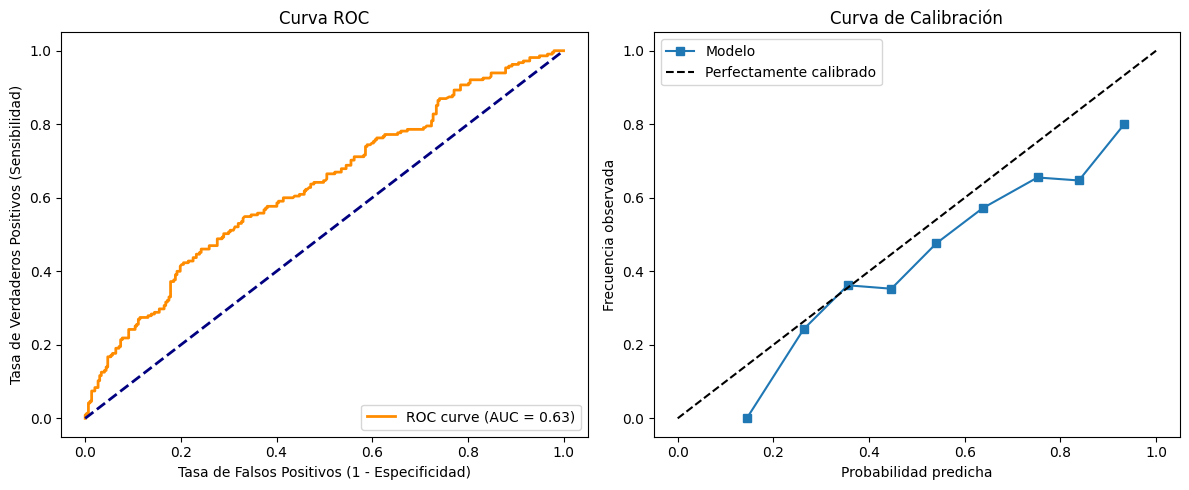

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve

# Cargar el modelo entrenado
modelo = joblib.load("mejor_modelo_gradient_boosting_ctgan.pkl")

# Obtener probabilidades predichas para la clase positiva (LRA=1)
y_proba = modelo.predict_proba(X_test)[:, 1]

# 2. Curva ROC
# ==========================
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")

# ==========================
# 3. Curva de calibración
# ==========================
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="uniform")

plt.subplot(1,2,2)
plt.plot(prob_pred, prob_true, "s-", label="Modelo")
plt.plot([0, 1], [0, 1], "k--", label="Perfectamente calibrado")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia observada")
plt.title("Curva de Calibración")
plt.legend()

plt.tight_layout()
plt.show()


In [48]:
import pandas as pd

# Resultados resumidos de tus corridas
resultados = {
    "Modelo": ["TVAE (0.5)", "TVAE (0.4)", "CTGAN (0.5)", "CTGAN (0.3)"],
    "Accuracy": [0.705, 0.609, 0.607, 0.502],
    "Precision": [0.646, 0.509, 0.577, 0.478],
    "Recall": [0.592, 0.791, 0.530, 0.957],
    "F1 Score": [0.618, 0.620, 0.552, 0.637],
    "Umbral": [0.5, 0.4, 0.5, 0.3]
}

# Crear DataFrame
df_comparacion = pd.DataFrame(resultados)

# Mostrar tabla
print(df_comparacion)

# Guardar como CSV para descargar
df_comparacion.to_csv("comparacion_tvae_ctgan.csv", index=False)

        Modelo  Accuracy  Precision  Recall  F1 Score  Umbral
0   TVAE (0.5)     0.705      0.646   0.592     0.618     0.5
1   TVAE (0.4)     0.609      0.509   0.791     0.620     0.4
2  CTGAN (0.5)     0.607      0.577   0.530     0.552     0.5
3  CTGAN (0.3)     0.502      0.478   0.957     0.637     0.3


Mayor recall (sensibilidad):

CTGAN + GB con umbral 0.3 → Recall ≈ 0.96, F1 ≈ 0.64.

Ideal para screening clínico, donde no se pueden perder casos de LRA aunque aumenten los falsos positivos.

Mejor balance general (F1 y precisión):

TVAE + GB con umbral 0.4–0.5 → Accuracy ≈ 0.70, F1 ≈ 0.62.

Útil para operación hospitalaria, con menos alarmas falsas y buena discriminación.

